## <p style="text-align:center;"> Final Project: Due Friday, May 16th, 12:30pm <br> STAT 426 (Spring 25) </p>
In this project, you will be comparing various classification methods on the fashion MNIST dataset available directly from the torchvision package. 

### Loading necessary packages
Let's first load the necessary packages. Note you may need to run 
```
pip install torchvision
```
which is need to download the dataset and transform it to a usable scale.

While all the critical packages have been listed below (run this to make sure you have access to all of them), feel free to load additional packages if you need them. 

In [130]:
# Basic packages
import matplotlib.pyplot as plt
import numpy as np

# Scipy packages
from ISLP import confusion_table
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import sklearn.model_selection as skm
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RC
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis as LDA, 
                                           QuadraticDiscriminantAnalysis as QDA)


# Dataset packages
import torchvision
import torchvision.transforms as transforms

# Torch packages
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset # To extract a subset of thr training data
from torchinfo import summary


#Extra stuff I wanted
from ISLP.svm import plot as plot_svm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.tree import plot_tree

from tabulate import tabulate


### Loading the dataset and scaling each pixel value to be in [-1,1]

We use the following transformations:
* ```transforms.ToTensor()``` converts image data pixel values to take values in [0,1]
* ```transforms.Normalize((0.5,), (0.5,))``` scales each pixel to take values in [-1,1], where the input arguments assume a single channel image

In [132]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))]) # The first one corresponds to the mean per channel,
                                           # The second is the std per sample
                                           # (Input - Mean)/Std   [0,1] --> [-1,1]

full_trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True,transform=transform)
testset  = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)

# There will be 10 classes in total
classes = full_trainset.classes
print(classes)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [133]:
print(len(full_trainset))

60000


We will use only 1000 training samples for most methods to keep the computations simple. We will still test on all test samples.

In [135]:
subset_indices = np.arange(1000)
trainset       = Subset(full_trainset, subset_indices)

Let us visualize a few of the samples with their class labels

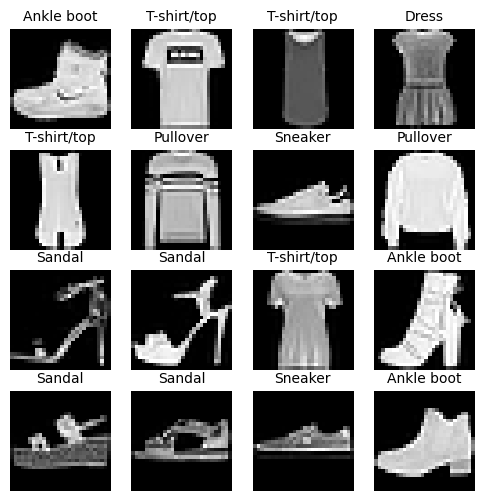

In [137]:
# Plot a few samples to visualize the data

fig,axs = plt.subplots(4,4,figsize=(6,6))
axs = axs.flatten()
for i in range(16):
    img = trainset[i][0].numpy().squeeze()
    axs[i].imshow(img,cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(f"{classes[trainset[i][1]]}",fontsize=10)


We also need to flatten the data before using it with non-DL methods, and convert to numpy arrays

In [139]:
X_train_flat = np.array([trainset[i][0].flatten() for i in range(1000)])
Y_train      = np.array([trainset[i][1] for i in range(1000)])
X_test_flat  = np.array([testset[i][0].flatten() for i in range(testset.data.shape[0])])
Y_test       = np.array([testset[i][1] for i in range(testset.data.shape[0])])

In [140]:
print(X_train_flat.shape)
print(Y_train.shape)
print(X_test_flat.shape)
print(Y_test.shape)

(1000, 784)
(1000,)
(10000, 784)
(10000,)


### PCA
Should the data really live in 784 dimensions? Principal Components Analysis (PCA) is one common method for finding representations of high-dimensional datasets in lower dimensional spaces. PCA seeks to find a low-dimensional representations that retain as much of the variation of the dataset as possible. To run PCA on this data, we first find the projection into lower dimensions for the training data, and then we apply the same projection to the testing data. Note we will use only the 1000 training data for this

In [142]:
# Apply PCA to training data 
pca = PCA(svd_solver='full') 
pca.fit(X_train_flat)

# Explained variance ratio
var_explained = np.cumsum(pca.explained_variance_ratio_)

# Find number of components to explain > 90% variance
pca_dim = np.argmax(var_explained > 0.90) + 1
print(f"Number of dimensions to explain 90% variance: {pca_dim}")

# Transform data into lower-dimensional space
X_pca_train = pca.transform(X_train_flat)[:, :pca_dim]
print(X_pca_train.shape)  # should be [n_samples, pca_dim]

# Apply the trained PCA to test data
X_pca_test_full = pca.transform(X_test_flat)  # Full PCA transform
X_pca_test = X_pca_test_full[:, :pca_dim]     # Slice to retained dimensions

Number of dimensions to explain 90% variance: 69
(1000, 69)


What was the advantage of this projection into the reduced dimensional space? We can expect the algorithms will run MUCH faster on the reduced dimension data, but will we sacrifice accuracy for this speed boost?

In the following sections, we will consider different classifiers. In your write-up, please give a ***brief*** description of each classifier before you use it.

#### A helper function to evaluate class-wise accuracy
Use this function for evaluating the performance of the various methods on the test set.

In [145]:
def acc_table(pred_labels,true_labels,print_class_accuracy = True):
    tab = np.array(confusion_table(true_labels,pred_labels))
    n_samples = true_labels.size

    total_acc = 0.0;
    class_acc = np.zeros(len(classes))
    for i,cn in enumerate(classes):
        class_acc[i] = float(tab[i,i])/float(sum(tab[i]))*100.0
        total_acc += float(tab[i,i])
        if print_class_accuracy:
            print(f'Accuracy for class: {cn:5s} is {class_acc[i]:.2f} %')
    total_acc *=100.0/n_samples
    print(f'Total accuracy is {total_acc:.2f} %')
    return class_acc, total_acc
        

### PART 1: KNN classification

Use KNN classification on the original flattened dataset, as well as the reduced data after PCA. You should tune the hyperparameter ```k``` using 5-fold cross validation, by considering the following values of k
```
k_vals   = [1,3,5,7,9,11]
```
You can perform CV tuning using ```GridSearchCV()``` which should be used in the following way
```python

kfold      = skm.KFold(5, random_state=0, shuffle=True)

grid_model = skm.GridSearchCV(<model>,
                              <dictionary of hyperparameters>,
                              refit=True, 
                              cv=kfold, 
                              scoring='accuracy')
```

where:
* ```<model>``` is the instance of the ML model you are training (in this case an instance of ```KNeighborsClassifier()```)
* ```<dictionary of hyperparameters>``` is the set of hyperparameters to step through using CV (in this case ```{'n_neighbors':k_vals}``` )

You need to train two models, one for the full dataset and another for the PCA data. In each case
* Extract the best model and report the best parameter for this model
* Find the model's predicition on the test data
* Use the provided ```acc_table()``` function to evaluate and save the within class test accuracy as well as the total test accuracy.

How do the two best models compare in terms of performance on the test dataset? Which model would you recommend using and why?

In [147]:
k_vals = [1,3,5,7,9,11]


kfold = skm.KFold(5,random_state = 0, shuffle = True)

model = KNeighborsClassifier()

dict_of_hyperparameters = {'n_neighbors':k_vals}

grid_model = skm.GridSearchCV(model,dict_of_hyperparameters,refit = True,cv = kfold,scoring = 'accuracy')

grid_model.fit(X_train_flat,Y_train)


knn_label = grid_model.predict(X_test_flat)    

flattend_data_accuracy,total_test_accuracy_knn_flattened = acc_table(knn_label,Y_test,print_class_accuracy = True)

the_best_param = grid_model.best_params_
print(the_best_param)

Accuracy for class: T-shirt/top is 77.50 %
Accuracy for class: Trouser is 93.20 %
Accuracy for class: Pullover is 60.40 %
Accuracy for class: Dress is 69.90 %
Accuracy for class: Coat  is 61.00 %
Accuracy for class: Sandal is 62.40 %
Accuracy for class: Shirt is 49.50 %
Accuracy for class: Sneaker is 92.00 %
Accuracy for class: Bag   is 90.60 %
Accuracy for class: Ankle boot is 94.10 %
Total accuracy is 75.06 %
{'n_neighbors': 1}


In [148]:
'''
similar process as above but instead for the PCA data

'''
model_pca = KNeighborsClassifier()

dict_of_hyperparameters = {'n_neighbors':k_vals}

grid_pca_model = skm.GridSearchCV(model_pca,dict_of_hyperparameters,refit = True,cv = kfold,scoring = 'accuracy')

grid_pca_model.fit(X_pca_train,Y_train)

pca_label = grid_pca_model.predict(X_pca_test)    

pca_accuracy,total_pca_accuracy_knn = acc_table(pca_label,Y_test,print_class_accuracy = True)


#the best parameter is k = 1
best_pca_param = grid_pca_model.best_params_
print(best_pca_param)


Accuracy for class: T-shirt/top is 74.50 %
Accuracy for class: Trouser is 93.30 %
Accuracy for class: Pullover is 56.80 %
Accuracy for class: Dress is 73.10 %
Accuracy for class: Coat  is 64.00 %
Accuracy for class: Sandal is 69.20 %
Accuracy for class: Shirt is 47.70 %
Accuracy for class: Sneaker is 90.40 %
Accuracy for class: Bag   is 92.70 %
Accuracy for class: Ankle boot is 94.20 %
Total accuracy is 75.59 %
{'n_neighbors': 1}


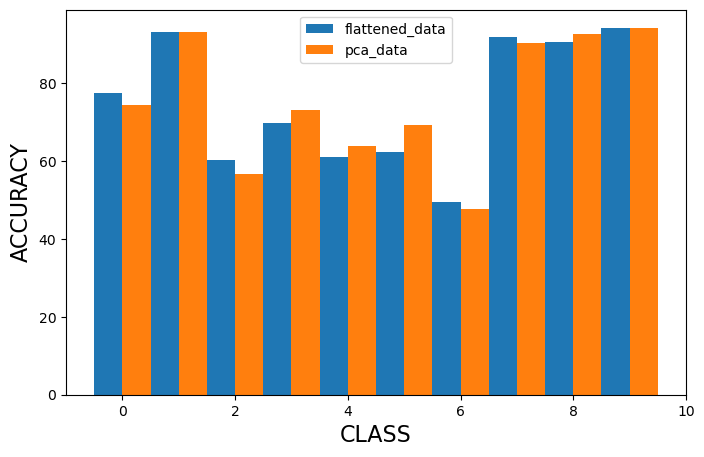

In [149]:
classes = np.array(classes)
flattened_data_acc = np.array(flattend_data_accuracy)
pca_data_acc = np.array(pca_accuracy)

width = 0.5
position = np.arange(len(classes))

plt.figure(figsize = (8,5))

plt.bar(position - width/2,flattend_data_accuracy,width,label ="flattened_data")
plt.bar(position+ width/2,pca_accuracy,width,label = "pca_data")
plt.xlabel("CLASS",fontsize = 16)
plt.ylabel("ACCURACY",fontsize = 16)
plt.legend()

In [150]:
'''
How do the two best models compare in terms of performance on the test dataset? Which model would you recommend using and why?

The two models compare roughly similar in terms of prediciting the classes with the total accuracy of the PCA model being slightly better 
overral. 
The PCA data accuracy is 75.59% whereas the flattened data accuracy is 75.06%
'''

'\nHow do the two best models compare in terms of performance on the test dataset? Which model would you recommend using and why?\n\nThe two models compare roughly similar in terms of prediciting the classes with the total accuracy of the PCA model being slightly better \noverral. \nThe PCA data accuracy is 75.59% whereas the flattened data accuracy is 75.06%\n'

### PART 2: Linear SVM classification on PCA data
Next try to see how well a linear SVM i.e., by setting ```kernel='linear'``` works on the PCA datasets. Use 5-fold cross validation as before by searching over ```C_vals = [0.001,0.01,0.1,10.0,100.0]```. In particular,
* Extract the best model and report the best parameter
* Find the model's predicition on the test data
* Evaluate and save the within class test accuracy as well as the total test accuracy.

In [152]:
#C_vals as per instructions
C_vals = [0.001,0.01,0.1,10.0,100.0]

#Linear Support Vector Classification
svm_linear = SVC(kernel='linear')

#5 fold cross validation
kfold = skm.KFold(5,random_state = 0, shuffle = True)

dict_of_hyperparameters = {'C':C_vals}

#model with best hyperparameters
grid_svm_pca = skm.GridSearchCV(svm_linear,dict_of_hyperparameters,refit = True, cv = kfold, scoring = 'accuracy')

#fitting the model above
grid_svm_pca.fit(X_pca_train, Y_train)

#predicting
pca_label = grid_svm_pca.predict(X_pca_test)


#extracting the best parameters
best_parameters_linearsvm = grid_svm_pca.best_params_

print(best_parameters_linearsvm)

#evaluating the accuracy
pca_accuracy_svm,total_pca_accuracy_svm = acc_table(pca_label,Y_test,print_class_accuracy = True)



{'C': 0.01}
Accuracy for class: T-shirt/top is 82.10 %
Accuracy for class: Trouser is 93.00 %
Accuracy for class: Pullover is 62.10 %
Accuracy for class: Dress is 82.90 %
Accuracy for class: Coat  is 70.80 %
Accuracy for class: Sandal is 85.70 %
Accuracy for class: Shirt is 50.10 %
Accuracy for class: Sneaker is 86.00 %
Accuracy for class: Bag   is 91.00 %
Accuracy for class: Ankle boot is 92.10 %
Total accuracy is 79.58 %


In [153]:
'''
for normalizing this confusion matrix

https://stackoverflow.com/questions/20927368/how-to-normalize-a-confusion-matrix

'''

'\nfor normalizing this confusion matrix\n\nhttps://stackoverflow.com/questions/20927368/how-to-normalize-a-confusion-matrix\n\n'

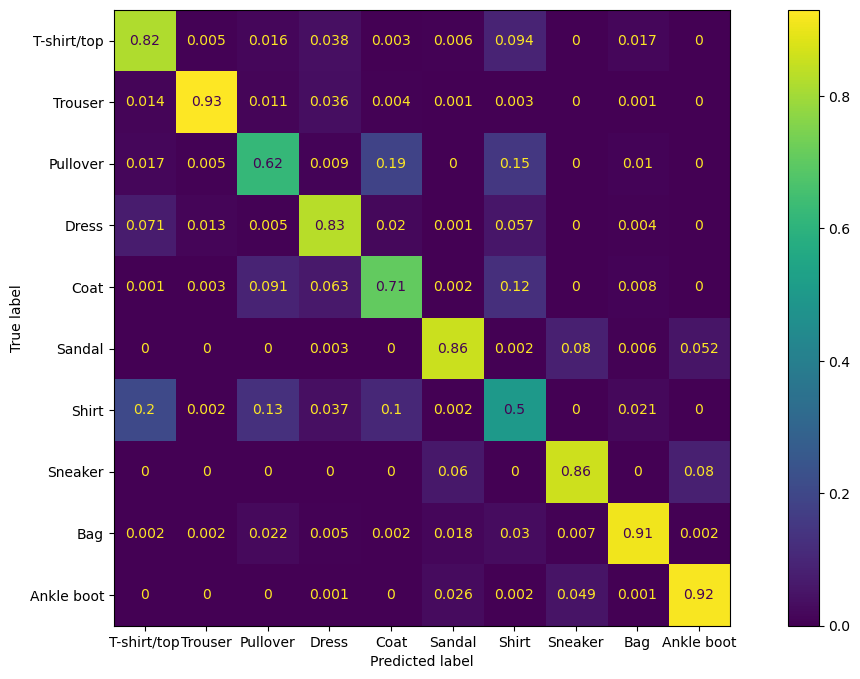

In [154]:
cm = confusion_matrix(Y_test,pca_label)
cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis] # to normalize it so that it has percentages
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = classes)
fig,ax = plt.subplots(figsize = (15,8))
disp.plot(ax = ax)
plt.show()

### PART 3: Nonlinear SVM classification on PCA data
How does a nonlinear SVM with ```kernel='rbf'``` perform on the PCA datasets. Repeat the steps of PART 2 by sUse 5-fold cross validation as before by searching over ```C_vals = [0.001,0.01,0.1,10.0,100.0]``` and ```gamma_vals  = [0.0001,0.001,0.01,0.1,1.0]```.

In [156]:
C_vals = [0.001,0.01,0.1,10.0,100.0]

gamma_vals  = [0.0001,0.001,0.01,0.1,1.0]

svm_rbf = SVC(kernel = 'rbf')

kfold = skm.KFold(5,random_state = 0, shuffle = True)

dict_of_hyperparameters = {'C':C_vals,'gamma':gamma_vals}

grid_svm_rbf = skm.GridSearchCV(svm_rbf,dict_of_hyperparameters,refit = True, cv = kfold, scoring = 'accuracy')


grid_svm_rbf.fit(X_pca_train, Y_train)

pca_label = grid_svm_rbf.predict(X_pca_test)


#extracting the best parameters
best_parameters_nonlinearsvm = grid_svm_rbf.best_params_

print(best_parameters_nonlinearsvm)

pca_acc_nonlinear_svm,total_pca_accuracy_nonlinear_svm = acc_table(pca_label,Y_test,print_class_accuracy = True)




{'C': 10.0, 'gamma': 0.001}
Accuracy for class: T-shirt/top is 80.80 %
Accuracy for class: Trouser is 94.20 %
Accuracy for class: Pullover is 66.20 %
Accuracy for class: Dress is 83.80 %
Accuracy for class: Coat  is 71.50 %
Accuracy for class: Sandal is 87.10 %
Accuracy for class: Shirt is 50.50 %
Accuracy for class: Sneaker is 87.90 %
Accuracy for class: Bag   is 92.70 %
Accuracy for class: Ankle boot is 92.70 %
Total accuracy is 80.74 %


In [157]:
'''
NOTE: Below Code I got from https://scikit-learn.org/1.4/auto_examples/svm/plot_svm_nonlinear.html
but I tweaked it a bit to only train on the best gamma value as mentioned above from the results. I also tweaked
it to include only the first 2 PCA components

I also used https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_with_legend.html for help with labeling
'''

'\nNOTE: Below Code I got from https://scikit-learn.org/1.4/auto_examples/svm/plot_svm_nonlinear.html\nbut I tweaked it a bit to only train on the best gamma value as mentioned above from the results. I also tweaked\nit to include only the first 2 PCA components\n\nI also used https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_with_legend.html for help with labeling\n'

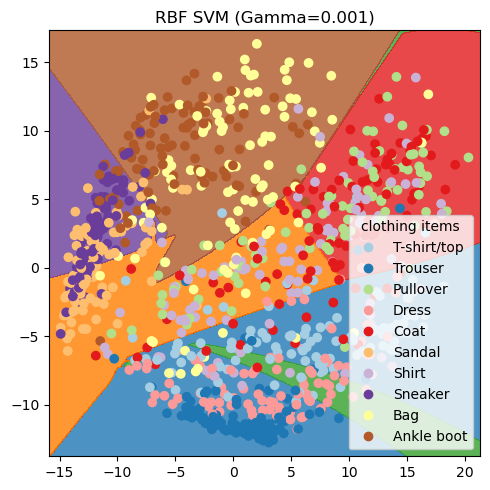

In [158]:
# Plot decision boundaries for each gamma value
gamma_values = [0.001]
X = X_pca_train[:,:2]
y = Y_train
plt.figure(figsize=(5, 5))
for i, gamma in enumerate(gamma_values, 1):
    # Train SVM with RBF kernel
    clf_rbf = SVC(kernel='rbf', gamma=gamma)
    clf_rbf.fit(X, y)

    # Create a mesh to plot decision boundaries
    h = 0.02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))

    # Plot decision boundary
    plt.subplot(1, 1, i)
    Z_rbf = clf_rbf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z_rbf = Z_rbf.reshape(xx.shape)
    plt.contourf(xx, yy, Z_rbf, cmap=plt.cm.Paired, alpha=0.8)
    p = plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)

    handles,labels = p.legend_elements()
    plt.legend(handles,classes,title = "clothing items")
    
    plt.title(f'RBF SVM (Gamma={gamma})')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

plt.tight_layout()
plt.show()


In [159]:
'''
I didn't use the below confusion matrix in report but here it is
in case
'''


"\nI didn't use the below confusion matrix in report but here it is\nin case\n"

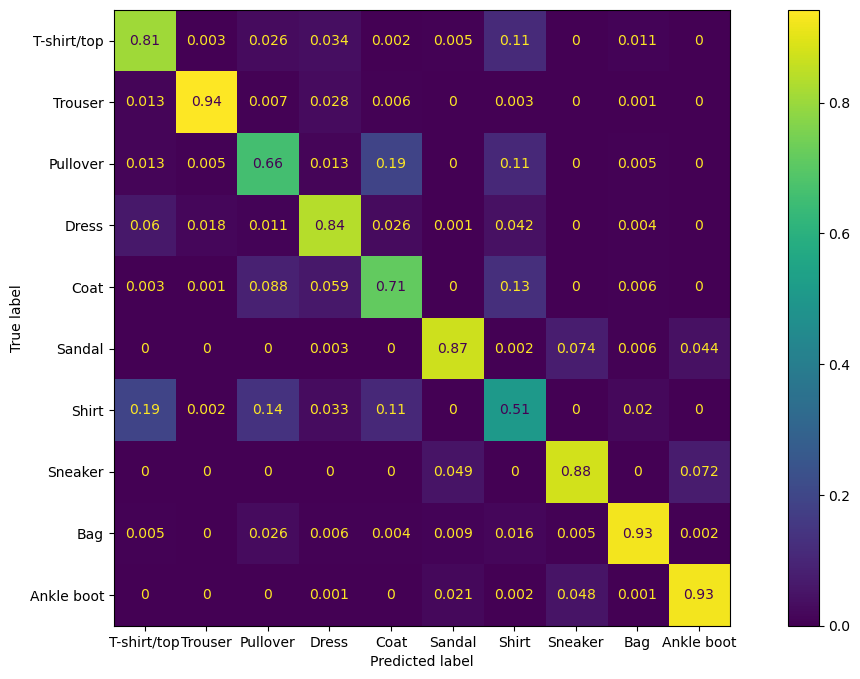

In [160]:
cm = confusion_matrix(Y_test,pca_label)
cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis] # to normalize it so that it has percentages
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = classes)
fig,ax = plt.subplots(figsize = (15,8))
disp.plot(ax = ax)
plt.show()

### PART 4: Random Forrest on PCA data
Next we test out random forrests. In this case, there aren't any hyperparameters to loop over (atleast we haven't discussed any in class). Reusing the codes shared with you, train a random forrest on the PCA data with ```B=500``. Save the within class test accuracy as well as the total test accuracy.

In [162]:
B = 500
p = X_pca_train.shape[1]
m = int(np.sqrt(p))
rforrest = RC(max_features = m,
              n_estimators = B,
              oob_score = True,
              random_state = 0)
rforrest.fit(X_pca_train,Y_train)

print(f"Random forrest OOB test accuracy estimate = {rforrest.oob_score_}")

test_rforrest_pred = rforrest.predict(X_pca_test)


within_class_RF,total_acc_RF = acc_table(test_rforrest_pred,Y_test,print_class_accuracy = True)


Random forrest OOB test accuracy estimate = 0.822
Accuracy for class: T-shirt/top is 82.10 %
Accuracy for class: Trouser is 91.70 %
Accuracy for class: Pullover is 63.30 %
Accuracy for class: Dress is 81.90 %
Accuracy for class: Coat  is 68.40 %
Accuracy for class: Sandal is 82.80 %
Accuracy for class: Shirt is 46.80 %
Accuracy for class: Sneaker is 86.00 %
Accuracy for class: Bag   is 91.50 %
Accuracy for class: Ankle boot is 92.80 %
Total accuracy is 78.73 %


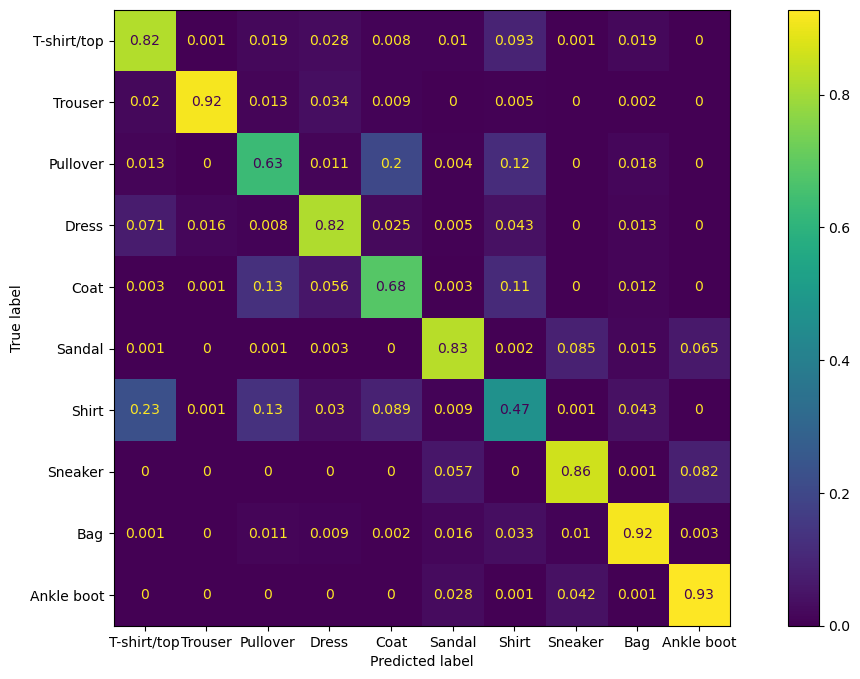

In [163]:
cm = confusion_matrix(Y_test,test_rforrest_pred)
cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis] # to normalize it so that it has percentages
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = classes)
fig,ax = plt.subplots(figsize = (15,8))
disp.plot(ax = ax)
plt.show()

### PART 5: LDA and QDA on PCA data
Repeat the process in PART 4 but for LDA and QDA. Again note that there aren't any hyperparameters here so CV is not required.

In [165]:
'''
LDA
'''
lda = LDA(store_covariance = True)
lda.fit(X_pca_train,Y_train)
lda_pred = lda.predict(X_pca_test)

lda_acc_claa,lda_acc_total = acc_table(lda_pred,Y_test,print_class_accuracy = True)
lda_cov = lda.covariance_


Accuracy for class: T-shirt/top is 79.00 %
Accuracy for class: Trouser is 91.20 %
Accuracy for class: Pullover is 58.50 %
Accuracy for class: Dress is 76.50 %
Accuracy for class: Coat  is 67.80 %
Accuracy for class: Sandal is 86.60 %
Accuracy for class: Shirt is 51.70 %
Accuracy for class: Sneaker is 81.30 %
Accuracy for class: Bag   is 88.70 %
Accuracy for class: Ankle boot is 93.70 %
Total accuracy is 77.50 %


In [166]:
LD_covariances = lda.explained_variance_ratio_
print(LD_covariances)

[0.44811484 0.2101604  0.08402945 0.07624884 0.06689878 0.04970227
 0.03934738 0.01766795 0.0078301 ]


In [167]:
'''
LDA scatter plot from:
https://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_lda.html?utm_source=chatgpt.com

'''

'\nLDA scatter plot from:\nhttps://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_lda.html?utm_source=chatgpt.com\n\n'

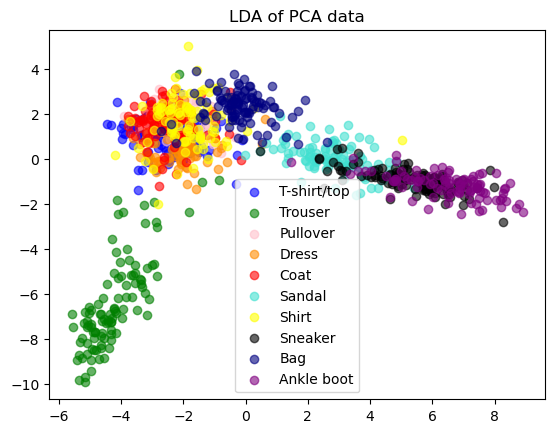

In [168]:
colors = ["blue","green","pink","darkorange","red","turquoise","yellow","black","navy","purple"]

lda_n = LDA(n_components = 2)
X_r2 = lda_n.fit(X_pca_train,Y_train).transform(X_pca_train)

plt.figure()
for color, i, class_name in zip(colors,[0,1,2,3,4,5,6,7,8,9],classes):
    plt.scatter(

        X_r2[Y_train == i,0], X_r2[Y_train == i,1],alpha = 0.6, color = color,label = class_name
    )

plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("LDA of PCA data")

plt.show()

In [169]:
'''
QDA
'''
qda = QDA(store_covariance = True)
qda.fit(X_pca_train,Y_train)

qda_pred = qda.predict(X_pca_test)
qda_cov = qda.covariance_
qda_acc_claa,qda_acc_total = acc_table(qda_pred,Y_test,print_class_accuracy = True)

#print(f"QDA covariance matrix is {qda_cov}")

print(len(qda_cov[0]))
print(len(qda_cov[0][0])) #so 69x69 per matrix which makes sense

Accuracy for class: T-shirt/top is 62.90 %
Accuracy for class: Trouser is 88.30 %
Accuracy for class: Pullover is 22.20 %
Accuracy for class: Dress is 70.00 %
Accuracy for class: Coat  is 64.10 %
Accuracy for class: Sandal is 85.20 %
Accuracy for class: Shirt is 65.80 %
Accuracy for class: Sneaker is 72.00 %
Accuracy for class: Bag   is 95.80 %
Accuracy for class: Ankle boot is 92.60 %
Total accuracy is 71.89 %
69
69


### PART 6: Comparison of non-DL models
Compare all the models trained so far. In particular, make the following 2 tables:
* One listing the total test accuracies
* Another listing the class wise test accuracy of the models
Note that you should have saved these quantities already after running each model.

Based on the tables:
* Which classes seem to be easiest to predict by most methods?
* Hardest to predict in general?
* Which model would you recommend and why? 

In [171]:
'''
for making the table

https://www.geeksforgeeks.org/how-to-make-a-table-in-python/

'''

'\nfor making the table\n\nhttps://www.geeksforgeeks.org/how-to-make-a-table-in-python/\n\n'

In [172]:

'''
THIS IS FOR THE PER CLASS ACCURACIES

flattened_data_accuracy,
pca_accuracy,
pca_accuracy_svm,

pca_acc_nonlinear_svm,

within_class_RF,
lda_acc_claa,
qda_acc_claa
'''

knn_flattened_data = list(flattend_data_accuracy)
knn_flattened_data.insert(0,"KNN Flattened data")

knn_pca = list(pca_accuracy)
knn_pca.insert(0,"KNN pca")

svm_within_class = list(pca_accuracy_svm)
svm_within_class.insert(0,"Linear SVM (PCA)")

nonlinearsvm = list(pca_acc_nonlinear_svm)
nonlinearsvm.insert(0,"Nonlinear SVM (PCA)")

random_forest_within_class = list(within_class_RF)
random_forest_within_class.insert(0,"Random Forest (PCA)")

lda_within_class = list(lda_acc_claa)
lda_within_class.insert(0,"LDA (PCA)")

qda_within_class = list(qda_acc_claa)
qda_within_class.insert(0,"QDA (PCA)")


in_class = [
knn_flattened_data,
knn_pca,
svm_within_class,
nonlinearsvm,
random_forest_within_class,
lda_within_class,
qda_within_class
]
headers = list(classes)
headers.insert(0,"Model")
print("*****Per Class Accuracies for all models*****")
print(tabulate(in_class,headers = headers,tablefmt = "mixed_grid"))

*****Per Class Accuracies for all models*****
┍━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━┯━━━━━━━━━━━┯━━━━━━━━━━━━┯━━━━━━━━━┯━━━━━━━━┯━━━━━━━━━━┯━━━━━━━━━┯━━━━━━━━━━━┯━━━━━━━┯━━━━━━━━━━━━━━┑
│ Model               │   T-shirt/top │   Trouser │   Pullover │   Dress │   Coat │   Sandal │   Shirt │   Sneaker │   Bag │   Ankle boot │
┝━━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━━┿━━━━━━━━━━━┿━━━━━━━━━━━━┿━━━━━━━━━┿━━━━━━━━┿━━━━━━━━━━┿━━━━━━━━━┿━━━━━━━━━━━┿━━━━━━━┿━━━━━━━━━━━━━━┥
│ KNN Flattened data  │          77.5 │      93.2 │       60.4 │    69.9 │   61   │     62.4 │    49.5 │      92   │  90.6 │         94.1 │
├─────────────────────┼───────────────┼───────────┼────────────┼─────────┼────────┼──────────┼─────────┼───────────┼───────┼──────────────┤
│ KNN pca             │          74.5 │      93.3 │       56.8 │    73.1 │   64   │     69.2 │    47.7 │      90.4 │  92.7 │         94.2 │
├─────────────────────┼───────────────┼───────────┼────────────┼─────────┼────────┼──────────┼─────────┼──────────

In [173]:
'''
THIS IS FOR THE TOTAL ACCURACIES

total_test_accuracy_knn_full
total_pca_accuracy
total_pca_accuracy_svm
total_pca_accuracy_nonlinear_svm
total_acc_RF
lda_acc_total
qda_acc_total

'''

knn_flattened_total = ["KNN Flattened data",total_test_accuracy_knn_flattened]
knn_pca_total = ["KNN pca",total_pca_accuracy_knn]
linear_svm_total = ["Linear SVM (PCA)",total_pca_accuracy_svm]

nonlinear_svm_total = ["Nonlinear SVM (PCA)",total_pca_accuracy_nonlinear_svm]

total_rf_acc = ["Random Forest (PCA)",total_acc_RF]
lda_acc_totall = ["LDA (PCA)",lda_acc_total]
qda_acc_totall = ["QDA (PCA)",qda_acc_total]


in_class = [
knn_flattened_total,
knn_pca_total,
linear_svm_total,
nonlinear_svm_total,
total_rf_acc,
lda_acc_totall,
qda_acc_totall
]
headers = ["Total Accuracy"]
headers.insert(0,"Classification Model")
print("*****Total Accuracies for all models*****")

print(tabulate(in_class,headers = headers,tablefmt = "mixed_grid"))

*****Total Accuracies for all models*****
┍━━━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━┑
│ Classification Model   │   Total Accuracy │
┝━━━━━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━━━━━┥
│ KNN Flattened data     │            75.06 │
├────────────────────────┼──────────────────┤
│ KNN pca                │            75.59 │
├────────────────────────┼──────────────────┤
│ Linear SVM (PCA)       │            79.58 │
├────────────────────────┼──────────────────┤
│ Nonlinear SVM (PCA)    │            80.74 │
├────────────────────────┼──────────────────┤
│ Random Forest (PCA)    │            78.73 │
├────────────────────────┼──────────────────┤
│ LDA (PCA)              │            77.5  │
├────────────────────────┼──────────────────┤
│ QDA (PCA)              │            71.89 │
┕━━━━━━━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━━━━━┙


### PART 7: Training a CNN on the image data
We finally want to test out how well a CNN would work on the image (non-flattened) dataset. ***We will continue to use only 1000 training samples.***

Now do the following based on the codes shared during class:
* Create data loaders for the training and test sets with a batch size of 100 and shuffling.
* Create a CNN architecture. You can choose the same CNN architecture we used in class, or change it if you feel like experimenting (just make sure the network is not too large or it will make the training very slow). You can use ```summary``` from torchinfo to check the consistency of the input and output shapes.
* Train the network with Adam optimizer for 50 epochs with the cross-entropy loss.
* Run the trained model on the test set (in eval() mode and without gradients) to get the predicted labels
* Calculate the class wise and total test accuracy.

How does the CNN compare with the previous aproaches? 



In [175]:
'''
ACCURACIES seem to change slightly every time I run it so it is possible that the numbers
below are a little different from what is on the report

'''

'\nACCURACIES seem to change slightly every time I run it so it is possible that the numbers\nbelow are a little different from what is on the report\n\n'

In [176]:
'''
did some reading from here about batch size https://stats.stackexchange.com/questions/153531/what-is-batch-size-in-neural-network
'''

'\ndid some reading from here about batch size https://stats.stackexchange.com/questions/153531/what-is-batch-size-in-neural-network\n'

In [177]:
batch_size  = 100

trainloader = torch.utils.data.DataLoader(trainset,batch_size = batch_size,shuffle = True)

testloader =  torch.utils.data.DataLoader(testset,batch_size = batch_size,shuffle = False)



In [178]:
class Net(nn.Module):
    def __init__(self,dropout_param = 0.5):
        super(Net, self).__init__()

        layer_list = []
        layer_list += [nn.Conv2d(1, 16, 3,padding="same"),nn.ReLU()]
        layer_list += [nn.MaxPool2d(2, 2)]
        layer_list += [nn.Conv2d(16, 32, 3,padding="same"),nn.ReLU()]
        layer_list += [nn.MaxPool2d(2, 2)]
        layer_list += [nn.Flatten(),nn.Dropout(dropout_param)]
        layer_list += [nn.Linear(1568, 128),nn.ReLU(),nn.Dropout(dropout_param)]
        layer_list += [nn.Linear(128, 10)]
        self.model = nn.ModuleList(layer_list)

    def forward(self, x):
        for i, layer in enumerate(self.model):
          x = layer(x) 
        return x


In [179]:
net = Net(dropout_param=0.5)
summary(net,
        input_size=(100,1,28,28),
        col_names=['input_size', 'output_size', 'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Net                                      [100, 1, 28, 28]          [100, 10]                 --
├─ModuleList: 1-1                        --                        --                        --
│    └─Conv2d: 2-1                       [100, 1, 28, 28]          [100, 16, 28, 28]         160
│    └─ReLU: 2-2                         [100, 16, 28, 28]         [100, 16, 28, 28]         --
│    └─MaxPool2d: 2-3                    [100, 16, 28, 28]         [100, 16, 14, 14]         --
│    └─Conv2d: 2-4                       [100, 16, 14, 14]         [100, 32, 14, 14]         4,640
│    └─ReLU: 2-5                         [100, 32, 14, 14]         [100, 32, 14, 14]         --
│    └─MaxPool2d: 2-6                    [100, 32, 14, 14]         [100, 32, 7, 7]           --
│    └─Flatten: 2-7                      [100, 32, 7, 7]           [100, 1568]               --
│    └─Dropout: 2-8            

In [180]:
criterion = nn.CrossEntropyLoss()

In [181]:
optimizer = optim.Adam(net.parameters())
for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    print(f'Epoch:{epoch + 1}, loss: {running_loss / len(trainloader):.3f}')
print('Finished Training')

Epoch:1, loss: 2.182
Epoch:2, loss: 1.607
Epoch:3, loss: 1.183
Epoch:4, loss: 1.022
Epoch:5, loss: 0.855
Epoch:6, loss: 0.763
Epoch:7, loss: 0.717
Epoch:8, loss: 0.710
Epoch:9, loss: 0.653
Epoch:10, loss: 0.642
Epoch:11, loss: 0.598
Epoch:12, loss: 0.573
Epoch:13, loss: 0.572
Epoch:14, loss: 0.563
Epoch:15, loss: 0.531
Epoch:16, loss: 0.531
Epoch:17, loss: 0.492
Epoch:18, loss: 0.506
Epoch:19, loss: 0.474
Epoch:20, loss: 0.453
Epoch:21, loss: 0.428
Epoch:22, loss: 0.424
Epoch:23, loss: 0.424
Epoch:24, loss: 0.405
Epoch:25, loss: 0.406
Epoch:26, loss: 0.384
Epoch:27, loss: 0.398
Epoch:28, loss: 0.372
Epoch:29, loss: 0.367
Epoch:30, loss: 0.369
Epoch:31, loss: 0.350
Epoch:32, loss: 0.346
Epoch:33, loss: 0.332
Epoch:34, loss: 0.349
Epoch:35, loss: 0.355
Epoch:36, loss: 0.313
Epoch:37, loss: 0.310
Epoch:38, loss: 0.286
Epoch:39, loss: 0.336
Epoch:40, loss: 0.289
Epoch:41, loss: 0.299
Epoch:42, loss: 0.283
Epoch:43, loss: 0.294
Epoch:44, loss: 0.273
Epoch:45, loss: 0.269
Epoch:46, loss: 0.2

In [182]:
net.eval()

N_test = testset.data.shape[0]
pred_labels = np.zeros(N_test)
true_labels = testset.targets.numpy()
i0 = 0
i1 = batch_size
with torch.no_grad():
    for data in testloader:
        images, _ = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted_batch = torch.max(outputs, 1)
        pred_labels[i0:i1] = np.copy(predicted_batch)
        i0 = min(i0 + batch_size,N_test)
        i1 = min(i1 + batch_size,N_test)

cnn_per_class,total_acc_cnn = acc_table(pred_labels,true_labels);



Accuracy for class: T-shirt/top is 86.00 %
Accuracy for class: Trouser is 96.50 %
Accuracy for class: Pullover is 67.20 %
Accuracy for class: Dress is 78.40 %
Accuracy for class: Coat  is 76.20 %
Accuracy for class: Sandal is 92.30 %
Accuracy for class: Shirt is 51.10 %
Accuracy for class: Sneaker is 91.40 %
Accuracy for class: Bag   is 95.00 %
Accuracy for class: Ankle boot is 94.60 %
Total accuracy is 82.87 %


In [183]:
cnn_chart = list(cnn_per_class)
in_class = [
cnn_chart
]
headers = list(classes)
print("*****Per Class Accuracies for CNN (1000 samples)*****")
print(tabulate(in_class,headers = headers,tablefmt = "mixed_grid"))

*****Per Class Accuracies for CNN (1000 samples)*****
┍━━━━━━━━━━━━━━━┯━━━━━━━━━━━┯━━━━━━━━━━━━┯━━━━━━━━━┯━━━━━━━━┯━━━━━━━━━━┯━━━━━━━━━┯━━━━━━━━━━━┯━━━━━━━┯━━━━━━━━━━━━━━┑
│   T-shirt/top │   Trouser │   Pullover │   Dress │   Coat │   Sandal │   Shirt │   Sneaker │   Bag │   Ankle boot │
┝━━━━━━━━━━━━━━━┿━━━━━━━━━━━┿━━━━━━━━━━━━┿━━━━━━━━━┿━━━━━━━━┿━━━━━━━━━━┿━━━━━━━━━┿━━━━━━━━━━━┿━━━━━━━┿━━━━━━━━━━━━━━┥
│            86 │      96.5 │       67.2 │    78.4 │   76.2 │     92.3 │    51.1 │      91.4 │    95 │         94.6 │
┕━━━━━━━━━━━━━━━┷━━━━━━━━━━━┷━━━━━━━━━━━━┷━━━━━━━━━┷━━━━━━━━┷━━━━━━━━━━┷━━━━━━━━━┷━━━━━━━━━━━┷━━━━━━━┷━━━━━━━━━━━━━━┙


### PART 8: Training a CNN on the FULL image data
Repeat Part 7 but now training on the full training set (not just 1000 samples). Since this is way more expensive, only run it for 10 epochs. How does the performance of this CNN compare to the previous one?

In [185]:
trainloader = torch.utils.data.DataLoader(full_trainset,batch_size = batch_size,shuffle = True)

testloader =  torch.utils.data.DataLoader(testset,batch_size = batch_size,shuffle = False)


In [186]:
net = Net(dropout_param=0.5)
summary(net,
        input_size=(100,1,28,28),
        col_names=['input_size', 'output_size', 'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Net                                      [100, 1, 28, 28]          [100, 10]                 --
├─ModuleList: 1-1                        --                        --                        --
│    └─Conv2d: 2-1                       [100, 1, 28, 28]          [100, 16, 28, 28]         160
│    └─ReLU: 2-2                         [100, 16, 28, 28]         [100, 16, 28, 28]         --
│    └─MaxPool2d: 2-3                    [100, 16, 28, 28]         [100, 16, 14, 14]         --
│    └─Conv2d: 2-4                       [100, 16, 14, 14]         [100, 32, 14, 14]         4,640
│    └─ReLU: 2-5                         [100, 32, 14, 14]         [100, 32, 14, 14]         --
│    └─MaxPool2d: 2-6                    [100, 32, 14, 14]         [100, 32, 7, 7]           --
│    └─Flatten: 2-7                      [100, 32, 7, 7]           [100, 1568]               --
│    └─Dropout: 2-8            

In [187]:
criterion = nn.CrossEntropyLoss()

In [188]:
optimizer = optim.Adam(net.parameters())
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    print(f'Epoch:{epoch + 1}, loss: {running_loss / len(trainloader):.3f}')
print('Finished Training')

Epoch:1, loss: 0.630
Epoch:2, loss: 0.428
Epoch:3, loss: 0.387
Epoch:4, loss: 0.358
Epoch:5, loss: 0.334
Epoch:6, loss: 0.319
Epoch:7, loss: 0.310
Epoch:8, loss: 0.299
Epoch:9, loss: 0.291
Epoch:10, loss: 0.285
Finished Training


In [189]:
net.eval()

N_test = testset.data.shape[0]
pred_labels = np.zeros(N_test)
true_labels = testset.targets.numpy()
i0 = 0
i1 = batch_size
with torch.no_grad():
    for data in testloader:
        images, _ = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted_batch = torch.max(outputs, 1)
        pred_labels[i0:i1] = np.copy(predicted_batch)
        i0 = min(i0 + batch_size,N_test)
        i1 = min(i1 + batch_size,N_test)

second_classes,second_total = acc_table(pred_labels,true_labels);


Accuracy for class: T-shirt/top is 85.30 %
Accuracy for class: Trouser is 97.10 %
Accuracy for class: Pullover is 90.50 %
Accuracy for class: Dress is 92.20 %
Accuracy for class: Coat  is 77.90 %
Accuracy for class: Sandal is 98.00 %
Accuracy for class: Shirt is 72.80 %
Accuracy for class: Sneaker is 97.30 %
Accuracy for class: Bag   is 98.20 %
Accuracy for class: Ankle boot is 96.30 %
Total accuracy is 90.56 %


In [190]:
cnn_chart = list(second_classes)
in_class = [
cnn_chart
]
headers = list(classes)
print("*****Per Class Accuracies for CNN (all samples)*****")
print(tabulate(in_class,headers = headers,tablefmt = "mixed_grid"))

*****Per Class Accuracies for CNN (all samples)*****
┍━━━━━━━━━━━━━━━┯━━━━━━━━━━━┯━━━━━━━━━━━━┯━━━━━━━━━┯━━━━━━━━┯━━━━━━━━━━┯━━━━━━━━━┯━━━━━━━━━━━┯━━━━━━━┯━━━━━━━━━━━━━━┑
│   T-shirt/top │   Trouser │   Pullover │   Dress │   Coat │   Sandal │   Shirt │   Sneaker │   Bag │   Ankle boot │
┝━━━━━━━━━━━━━━━┿━━━━━━━━━━━┿━━━━━━━━━━━━┿━━━━━━━━━┿━━━━━━━━┿━━━━━━━━━━┿━━━━━━━━━┿━━━━━━━━━━━┿━━━━━━━┿━━━━━━━━━━━━━━┥
│          85.3 │      97.1 │       90.5 │    92.2 │   77.9 │       98 │    72.8 │      97.3 │  98.2 │         96.3 │
┕━━━━━━━━━━━━━━━┷━━━━━━━━━━━┷━━━━━━━━━━━━┷━━━━━━━━━┷━━━━━━━━┷━━━━━━━━━━┷━━━━━━━━━┷━━━━━━━━━━━┷━━━━━━━┷━━━━━━━━━━━━━━┙


In [191]:
cnn_total_1000 = [total_acc_cnn]
cnn_total_all = [second_total]
total_acc_cnn = [
cnn_total_1000,
cnn_total_all
]
headers = ["Total Accuracy"]
print("Total accuracies for both CNN models")
print(tabulate(total_acc_cnn, headers = headers, tablefmt = "mixed_grid"))

Total accuracies for both CNN models
┍━━━━━━━━━━━━━━━━━━┑
│   Total Accuracy │
┝━━━━━━━━━━━━━━━━━━┥
│            82.87 │
├──────────────────┤
│            90.56 │
┕━━━━━━━━━━━━━━━━━━┙
